<a href="https://colab.research.google.com/github/nagarajgn01/anomaly-detection-autoencoder-h2o/blob/main/Anomaly_Detection_with_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Necessary Library

In [1]:
# Install necessary library
install.packages('caret')
install.packages('e1071')
install.packages('ROCR')
install.packages('bannerCommenter')
install.packages("h2o", repos=(c("http://s3.amazonaws.com/h2o-release/h2o/master/1497/R", getOption("repos"))))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Import Library

In [2]:
# Import libray and intialize H20 instance
library(tidyverse)
library(caret)
library(h2o)
library(bannerCommenter)
options(warn=-1)
h2o.init(nthreads = -1)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching 

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         6 hours 48 minutes 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.32.0.1 
    H2O cluster version age:    6 months and 11 days !!! 
    H2O cluster name:           H2O_started_from_R_root_sed368 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   2.67 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 4.0.5 (2021-03-31) 



# Function Definition

In [3]:
##----------------------------------------------------------------
##                Function to load data from CSV                --
##----------------------------------------------------------------
loadSourceData <- function(){  
  return(read.csv("creditcard.csv"))
}


##---------------------------------------------------------------
##    Function to transform Time & Class variable in factor    --
##---------------------------------------------------------------
preparaData <- function(creditcard){
  
  creditcard$Time <- as.factor(ifelse(creditcard$Time <= 15012, "gr1", # mean 1st Qu.
                                    ifelse(creditcard$Time <= 25610, "gr2", # mean mean
                                           ifelse(creditcard$Time <= 35731, "gr3", # mean 3rd Qu
                                                  "gr4"))))
  creditcard$Class <- factor(creditcard$Class)  
  return(creditcard)
}

##-------------------------------------------------------------------
##  Function to split input data into 3 sets (2 training, 1 test)  --
##------------------------------------------------------------------- 
splitData <- function(inputdf){
  
  splits <- h2o.splitFrame(creditcard_hf, ratios = c(0.4,0.4), seed = 42)
  return(list(splits[[1]],splits[[2]],splits[[3]])) 
}

##---------------------------------------------------------------
##            Function to build Deep Learning model            --
##---------------------------------------------------------------
buildModel <- function(features, trainData, hiddenUnits, labels=NULL, enableAutoEncode=FALSE, reproducible=TRUE, 
                        ignoreConstCol=FALSE, balanceClasses=TRUE, seedNo=42,  epochValue=100, activationFunc='Tanh',
                        model_name=NULL,pretrainedEncoder=NULL){
  
  # Check for autoencoder for supervised and unsupervised model
  if(enableAutoEncode){
    model <- h2o.deeplearning(x = features, training_frame = trainData, autoencoder = enableAutoEncode, 
                             reproducible = reproducible, ignore_const_cols = ignoreConstCol, 
                             seed = seedNo, hidden = hiddenUnits, model_id = model_name,
                             epochs = epochValue, activation = activationFunc)
  }
  else{
    model <- h2o.deeplearning(x = features, y=labels, training_frame = trainData, balance_classes = balanceClasses, 
                             reproducible = reproducible, ignore_const_cols = ignoreConstCol, 
                             seed = seedNo, hidden = hiddenUnits, pretrained_autoencoder = pretrainedEncoder,
                             epochs = epochValue, activation = activationFunc)
  }
  return(model)
}

##------------------------------------------------------------------------
##  Function to get Reconstructed MSE score using H20 anomaly function  --
##------------------------------------------------------------------------
getAnomalyScore <- function(model, trainData, perFeature=FALSE){
  
  reconstructMSE <- h2o.anomaly(model, trainData, per_feature = perFeature) %>% as.data.frame() %>% mutate(Class = as.vector(trainData[, 31]))
  return(reconstructMSE)
}

##----------------------------------------------------------------
##     Function to calculate Threshold value using quantile     --
##----------------------------------------------------------------
calculateThreshold <- function(reconstructMSE,probValue){
  
  return(quantile(reconstructMSE, probs = probValue))
}

##----------------------------------------------------------------
##     Function to calculate Metrics for Unsupervised Model     --
##----------------------------------------------------------------
calculateMetricsUnSup <- function(testReconstructMSE, threshold, testData){
  results_unsup <- data.frame(as.integer(testReconstructMSE > threshold),as.vector(testData[, 31]))
  colnames(results_unsup) <- c("predict","actual")
  df <- results_unsup %>% group_by(actual, predict) %>% summarise(n = n()) %>% mutate(freq = n / sum(n))
  txt <- paste(round(df[[4]][4]*100,2),'% of fraud cases were correctly identified\n',round(df[[4]][1]*100,2),'% of non-fraud cases were correctly identified')
  banner(txt, centre = TRUE, bandChar = "-")
}

##---------------------------------------------------------------
##      Function to Plot Anomaly Detection with Threshold      --
##---------------------------------------------------------------
plotUnSupResults <- function(reconstructMSE,testReconstructMSE,threshold){
  results <- data.frame(rbind(reconstructMSE,testReconstructMSE), threshold)
  results$rowname = seq.int(nrow(results))
  cat('\n')
  options(repr.plot.width=8, repr.plot.height=6)
  ggplot(results, aes(x = as.numeric(rowname), y = Reconstruction.MSE, color = as.factor(Class))) +
  geom_point(alpha = 1,size = 3) +
  geom_hline(yintercept = threshold,linetype="dashed", size=2) +
  scale_color_brewer(palette = "Set1") +
  labs(x = "instance number", color = "Class") +
  theme(axis.text=element_text(size=14),
        axis.title=element_text(size=14,face="bold"),
        legend.text=element_text(size=14),
        legend.title=element_text(size=14),
        plot.title = element_text(size=22,hjust = 0.5)) +
  ggtitle("Anomaly Detection Results") 
}

In [4]:
##---------------------------------------------------------------------
##  Function to get Features of Hidden Layer from AutoEncoder Model  --
##---------------------------------------------------------------------
getHiddenFeatures <- function(model,trainData,hiddenLayer){
  train_features <- h2o.deepfeatures(model, trainData, layer = hiddenLayer) %>%
    as.data.frame() %>%
    mutate(Class = as.factor(as.vector(trainData[, 31]))) %>%
    as.h2o()
  return(train_features)
}

##----------------------------------------------------------------
##      Function to calculate Metrics for Supervised Model      --
##----------------------------------------------------------------
calculateMetrics <- function(predict){
  cat('\n')
  options(repr.plot.width=6, repr.plot.height=4)
  predict %>%
  ggplot(aes(x = actual, fill = predict)) +
    geom_bar() +
    theme_bw() +
    scale_fill_brewer(palette = "Set1") +
    facet_wrap( ~ actual, scales = "free", ncol = 2)+
    theme(axis.text=element_text(size=14),
        axis.title=element_text(size=14,face="bold"),
        legend.text=element_text(size=14),
        legend.title=element_text(size=14),
        plot.title = element_text(size=22,hjust = 0.5)) +
    ggtitle("Anomaly Classification")
}

##---------------------------------------------------------------
##               Function to print Model Summary               --
##---------------------------------------------------------------
printSummary <- function(predict){
  df <- predict %>% group_by(actual, predict) %>% summarise(n = n()) %>% mutate(freq = n / sum(n))
  txt <- paste('Total test records : ' , dim(test)[1],'\n Total Fraud Cases : ',df[[3]][4]+df[[3]][3],'\n True Positive : ',df[[3]][4],
              '\n False Positive : ', df[[3]][2],'\n True Negative : ', df[[3]][1],
              '\n False Negative : ', df[[3]][3],'\n',round(df[[4]][4]*100,2),'% of fraud cases were correctly identified',
              '\n',round(df[[4]][1]*100,2),'% of non-fraud cases were correctly identified')
  banner(txt, centre = TRUE, bandChar = "-")
}

##---------------------------------------------------------------------------------
##  Function to calculate Metrics for Supervised Model with different threshold  --
##---------------------------------------------------------------------------------
calculateMetricsThreshold <- function(predict,threshold){
  df <- predict %>% mutate(predict = ifelse(pred$p1 > threshold, 1, 0)) %>% group_by(actual, predict) %>% summarise(n = n()) %>% mutate(freq = n / sum(n))
  txt <- paste('Total test records : ' , dim(test)[1],'\n Total Fraud Cases : ',df[[3]][4]+df[[3]][3],'\n True Positive : ',df[[3]][4],
              '\n False Positive : ', df[[3]][2],'\n True Negative : ', df[[3]][1],
              '\n False Negative : ', df[[3]][3],'\n',round(df[[4]][4]*100,2),'% of fraud cases were identified')
  banner(txt, centre = TRUE, bandChar = "-")
  cat('\n')
  predict %>%
  ggplot(aes(x = actual, fill = predict)) +
    geom_bar() +
    theme_bw() +
    scale_fill_brewer(palette = "Set1") +
    facet_wrap( ~ actual, scales = "free", ncol = 2)+
    theme(axis.text=element_text(size=14),
        axis.title=element_text(size=14,face="bold"),
        legend.text=element_text(size=14),
        legend.title=element_text(size=14),
        plot.title = element_text(size=22,hjust = 0.5)) +
    ggtitle("Anomaly Classification")
}

##-----------------------------------------------------------------
##  Function to plot Precision-Recall & Sensitivity-Specificity  --
##-----------------------------------------------------------------
plotMetrics <- function(pred){
  cat('\n')
  options(repr.plot.width=8, repr.plot.height=4)
  library(ROCR)
  line_integral <- function(x, y) {
    dx <- diff(x)
    end <- length(y)
    my <- (y[1:(end - 1)] + y[2:end]) / 2
    sum(dx * my)
  } 
  prediction_obj <- prediction(pred$p1, pred$actual)
  par(mfrow = c(1, 2))
  par(mar = c(5.1,4.1,4.1,2.1))
  # precision-recall curve
  perf1 <- performance(prediction_obj, measure = "prec", x.measure = "rec") 
  x <- perf1@x.values[[1]]
  y <- perf1@y.values[[1]]
  y[1] <- 0
  plot(perf1, main = paste("Area Under the\nPrecision-Recall Curve:\n", round(abs(line_integral(x,y)), digits = 3)))
  # sensitivity-specificity curve
  perf2 <- performance(prediction_obj, measure = "sens", x.measure = "spec") 
  x <- perf2@x.values[[1]]
  y <- perf2@y.values[[1]]
  y[1] <- 0
  plot(perf2, main = paste("Area Under the\nSensitivity-Specificity Curve:\n", round(abs(line_integral(x,y)), digits = 3)))
}

##-----------------------------------------------------------------
##  Function to plot results based on different Threshold value  --
##-----------------------------------------------------------------
plotDiffThreshold <- function(pred){
  thresholds <- seq(from = 0, to = 1, by = 0.1)
  pred_thresholds <- data.frame(actual = pred$actual)

  for (threshold in thresholds) {  
    prediction <- ifelse(pred$p1 > threshold, 1, 0)
    prediction_true <- ifelse(pred_thresholds$actual == prediction, TRUE, FALSE)
    pred_thresholds <- cbind(pred_thresholds, prediction_true)
  }

  colnames(pred_thresholds)[-1] <- thresholds
  options(repr.plot.width=8, repr.plot.height=6)
  pred_thresholds %>%
    gather(x, y, 2:ncol(pred_thresholds)) %>%
    group_by(actual, x, y) %>%
    summarise(n = n()) %>%
    ggplot(aes(x = as.numeric(x), y = n, color = actual)) +
      geom_vline(xintercept = 0.8, alpha = 0.5) +
      geom_line() +
      geom_point(alpha = 0.5) +
      theme_bw() +
      facet_wrap(actual ~ y, scales = "free", ncol = 2) +
      labs(x = "prediction threshold",
          y = "number of instances")+
      theme(axis.text=element_text(size=14),
          axis.title=element_text(size=14,face="bold"),
          legend.text=element_text(size=14),
          legend.title=element_text(size=14),
          plot.title = element_text(size=22,hjust = 0.5)) +
      ggtitle("Prediction Thresholds")
}

# Un-Supervised Learning with AutoEncoder Model

  |======================================================================| 100%
  |======================================================================| 100%


`summarise()` has grouped output by 'actual'. You can override using the `.groups` argument.




##---------------------------------------------------------------
##      84.21 % of fraud cases were correctly identified       --
##     99.45 % of non-fraud cases were correctly identified    --
##---------------------------------------------------------------


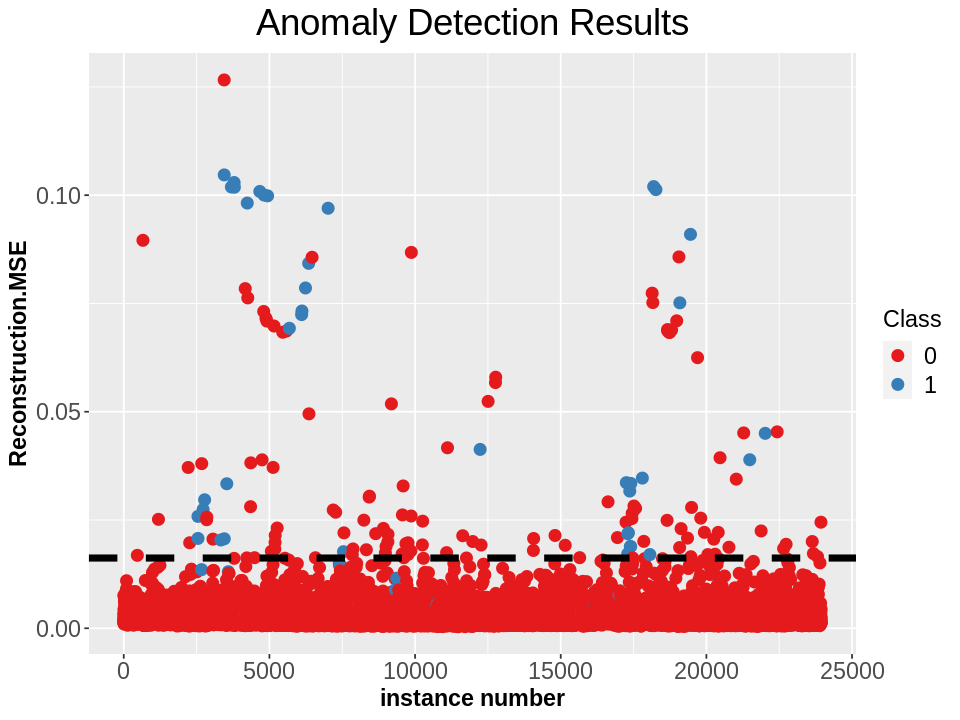

In [5]:
# Load Data
creditcard <- loadSourceData()
creditcard <- preparaData(creditcard)

# Convert Data to H2oFrame
creditcard_hf <- as.h2o(creditcard)

# Split Data
rtList <- splitData(creditcard_hf)
train_unsupervised <- rtList[[1]]
train_supervised <- rtList[[2]]
test <- rtList[[3]]

# Define Feature space
response <- "Class" 
features <- setdiff(colnames(train_unsupervised), response)

# Build Unsupervised model with Auto Encoders
modelUnSup <- buildModel(features = features,trainData = train_unsupervised, hiddenUnits = c(10,2,10)
                          ,enableAutoEncode=TRUE,model_name='modelUnSup')

# Get Reconstructed MSE score for each observation in training data
reconstructMSE <- getAnomalyScore(modelUnSup,train_unsupervised)

# Calculate threshold
threshold <- calculateThreshold(reconstructMSE$Reconstruction.MSE,0.994)

# Get Reconstructed MSE score for test data
testReconstructMSE <- getAnomalyScore(modelUnSup,test)

# Calculate and plot model performance
calculateMetricsUnSup(testReconstructMSE$Reconstruction.MSE,threshold,test)
plotUnSupResults(reconstructMSE,testReconstructMSE,threshold)

# Supervised Learning with AutoEncoder Features

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


`summarise()` has grouped output by 'actual'. You can override using the `.groups` argument.




##---------------------------------------------------------------
##                 Total test records :  7901                  --
##                   Total Fraud Cases :  19                   --
##                     True Positive :  17                     --
##                   False Positive :  4684                    --
##                    True Negative :  3198                    --
##                     False Negative :  2                     --
##       89.47 % of fraud cases were correctly identified      --
##     40.57 % of non-fraud cases were correctly identified    --
##---------------------------------------------------------------


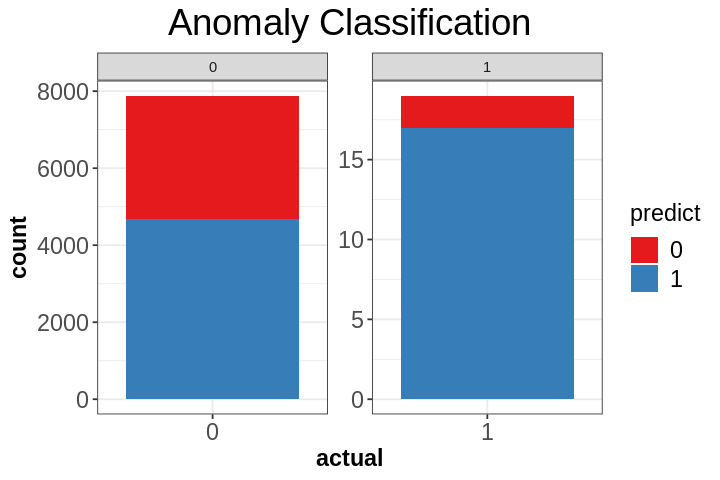

In [6]:
# Get Features from Hidden Layer from AutoEncoder Model
train_features <- getHiddenFeatures(modelUnSup,train_unsupervised,hiddenLayer=3)

# Define feature space
features_dim <- setdiff(colnames(train_features), response)

# Build Supervised Model with output Hidden Layer
modelSup <- buildModel(features = features_dim,labels = response,trainData = train_features,hiddenUnits = c(10, 2, 10))

# Get Hidden Layer Output for test data
test_dim <- getHiddenFeatures(modelUnSup,test,hiddenLayer=3)

# Predict on test Data
pred <- as.data.frame(h2o.predict(object = modelSup, newdata = test_dim)) %>%  mutate(actual = as.vector(test[, 31]))

# Calculate and plot Model Metrics
printSummary(pred)
calculateMetrics(pred)

# Hybrid Semi-Supervised Learning with pre-trained AutoEncoder Model

  |======================================================================| 100%
  |======================================================================| 100%


`summarise()` has grouped output by 'actual'. You can override using the `.groups` argument.




##---------------------------------------------------------------
##                 Total test records :  7901                  --
##                   Total Fraud Cases :  19                   --
##                     True Positive :  15                     --
##                     False Positive :  10                    --
##                    True Negative :  7872                    --
##                     False Negative :  4                     --
##       78.95 % of fraud cases were correctly identified      --
##     99.87 % of non-fraud cases were correctly identified    --
##---------------------------------------------------------------


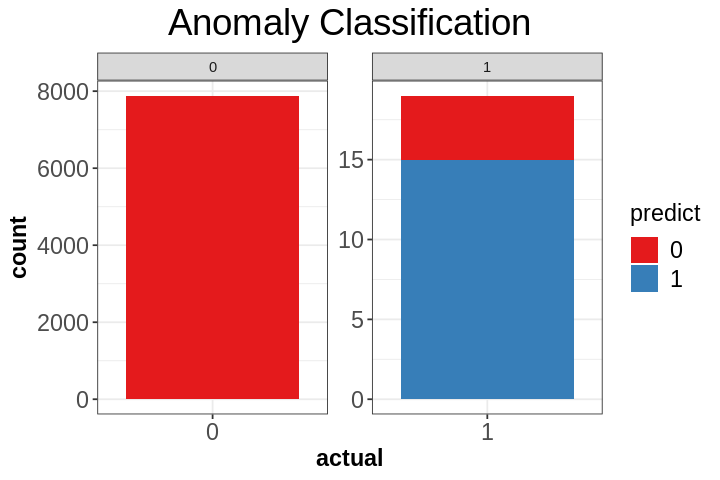

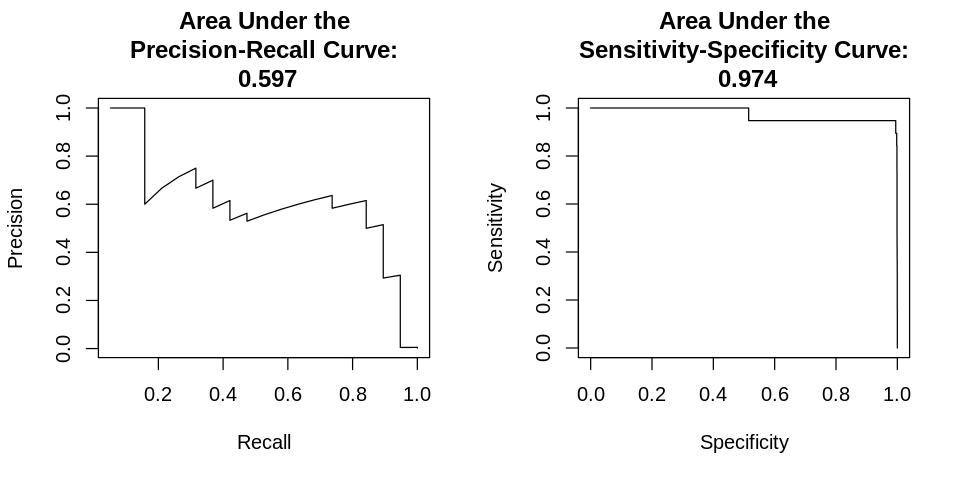

In [7]:
# Build Supervised Learning along with preTrained Autoencoder model
modelPreTrainSup <- buildModel(features = features,labels = response,trainData = train_supervised,
                                hiddenUnits = c(10, 2, 10), pretrainedEncoder='modelUnSup')

# Predict on test data
pred <- as.data.frame(h2o.predict(object = modelPreTrainSup, newdata = test)) %>%  mutate(actual = as.vector(test[, 31]))

# Calculate and plot model metrics
printSummary(pred)
calculateMetrics(pred)
plotMetrics(pred)

# Threshold Trade-Off

`summarise()` has grouped output by 'actual', 'x'. You can override using the `.groups` argument.



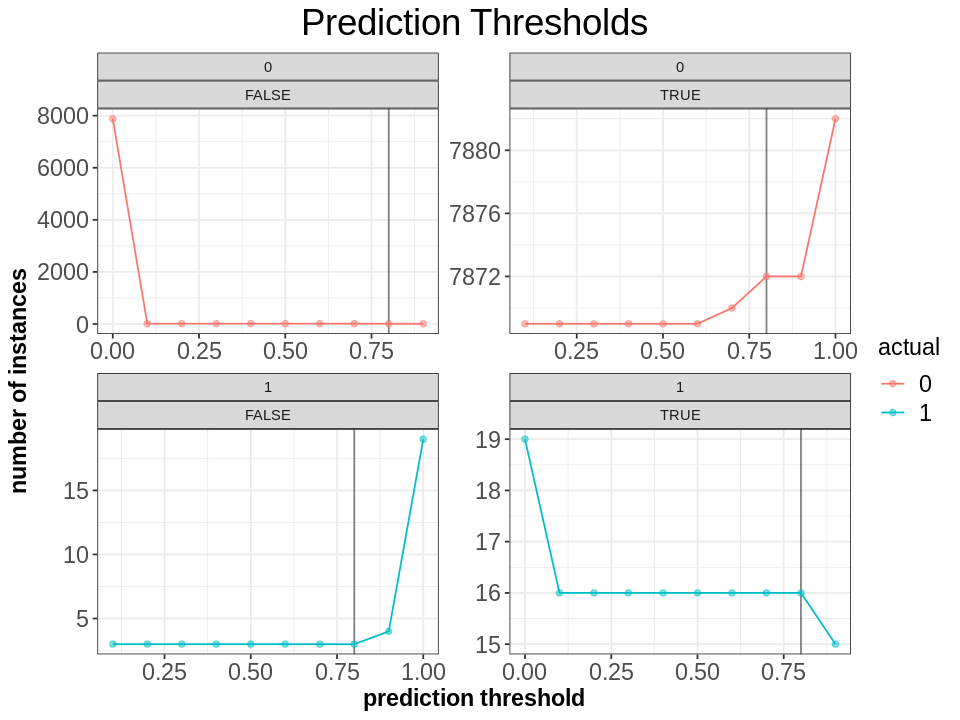

In [8]:
# Check for Different Threshold
plotDiffThreshold(pred)

# Metrics Summary for new Threshold

`summarise()` has grouped output by 'actual'. You can override using the `.groups` argument.




##---------------------------------------------------------------
##                 Total test records :  7901                  --
##                   Total Fraud Cases :  19                   --
##                     True Positive :  16                     --
##                     False Positive :  10                    --
##                    True Negative :  7872                    --
##                     False Negative :  3                     --
##       84.21 % of fraud cases were correctly identified      --
##     99.87 % of non-fraud cases were correctly identified    --
##---------------------------------------------------------------


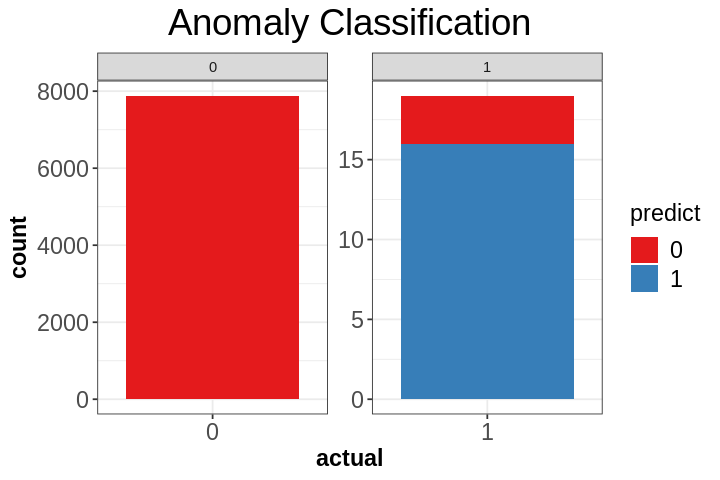

In [9]:
# Choose Threshold
threshold = 0.8
pred <- pred %>% mutate(predict = ifelse(pred$p1 > threshold, 1, 0))
pred$predict <- as.character(pred$predict)
printSummary(pred)
calculateMetrics(pred)